In [26]:
using Revise

using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using ITensors

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true

function sumqtt(qtt) where {T}
    if length(qtt) == 0
        return T(0)
    end
    
    v = sum(qtt[end], dims=2)
    for t in qtt[length(qtt)-1:-1:1]
        v *= t
    end
    return v
end

sumqtt (generic function with 1 method)

In [92]:
a, b = 0, 3
A = 1
B = 1e-6
nquantics = 62
ndiscretization = 2^nquantics
#xvals = range(a, b; length=ndiscretization+1)[2:end]

xvals(i) = a + (b - a) * i / ndiscretization

step = div(ndiscretization, 9876)
nadd = 4

tolerance = 1e-8

function f(q)
    x = xvals(quantics_to_index(q)[1])
    return exp(-x^2 / A^2) * cos(2pi * x / B) * cos(0.1 * 2pi * x / B)
end

struct cachedfunc{ValueType}
    f::Function
    d::Dict{Vector{Int}, ValueType}
    
    function cachedfunc(::Type{ValueType}, f::Function) where ValueType
        new{ValueType}(f, Dict())
    end
end
    
function (cf::cachedfunc{ValueType})(x::Vector{Int})::ValueType where {ValueType}
    return get!(cf.d, x) do
        cf.f(x)
    end
end
    
Base.broadcastable(x::cachedfunc) = Ref(x)
    
cf = cachedfunc(Float64, f)

#cf = TCI.CachedFunction{Float64}(f, fill(2, nquantics));
#plot(xvals, [f(index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization])

In [93]:
firstpivot = TCI.optfirstpivot(f, fill(2, nquantics), 
    [1, fill(2, nquantics-2)..., 1])

additionalpivots = Vector{Int}[]#index_to_quantics(div(ndiscretization * i, nadd), nquantics) for i in 1:nadd]


time = @elapsed tci, ranks, errors = TCI.crossinterpolate(
    Float64,
    cf,
    fill(2, nquantics),
    firstpivot,
    tolerance=tolerance,
    #additionalpivots=additionalpivots
)

print("Elapsed: $time s for $(maximum(ranks)) iterations.")

Elapsed: 0.407088041 s for 18 iterations.

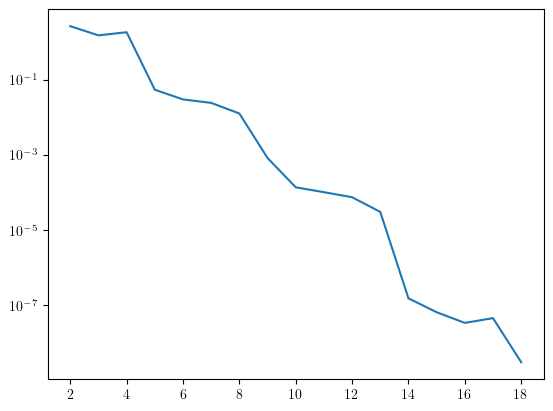

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2c6c28820>

In [94]:
semilogy(ranks, errors)

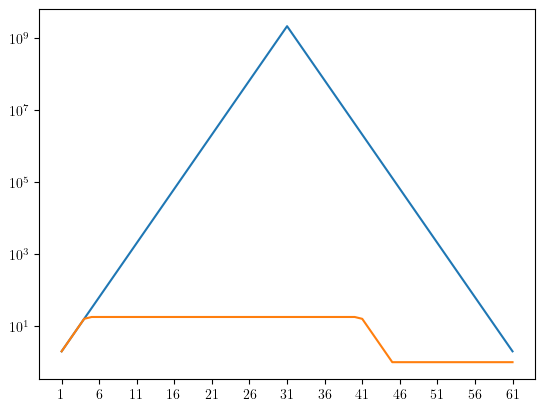

In [95]:
semilogy(1:nquantics-1, [min(2^x, 2^(nquantics-x)) for x in 1:nquantics-1])
semilogy(1:nquantics-1, TCI.linkdims(tci))
xticks(1:5:nquantics-1);

In [96]:
mps = qtt_to_mps(TCI.tensortrain(tci))
tcieval = [evaluate_mps(mps, siteinds(mps), index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization]
original = [f(index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization]
difference = original .- tcieval;

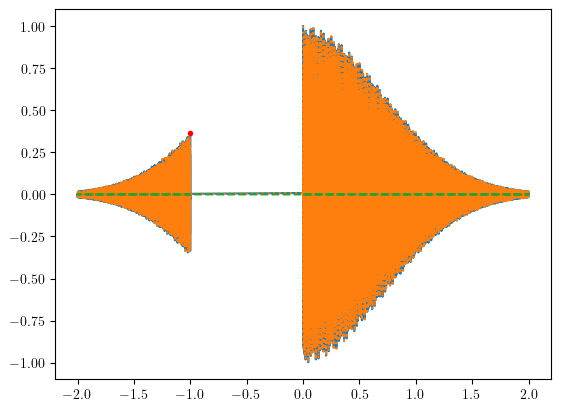

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2961586a0>

In [97]:
xstep = xvals.(1:step:ndiscretization)
plot(xstep, original)
plot(xstep, tcieval, ":")
plot(xstep, difference, "--")

plot([xvals(quantics_to_index(firstpivot)[1])], [f(firstpivot)], "r.")
plot([xvals(quantics_to_index(a)[1]) for a in additionalpivots], [f(a) for a in additionalpivots], "k.")
#for pivot in tci.Jset[1].fromint
#    plot([xvals[quantics_to_index(vcat(pivot, [1]))[1]]], [f(vcat(pivot, [1]))], "k+", label="pivot")
#end

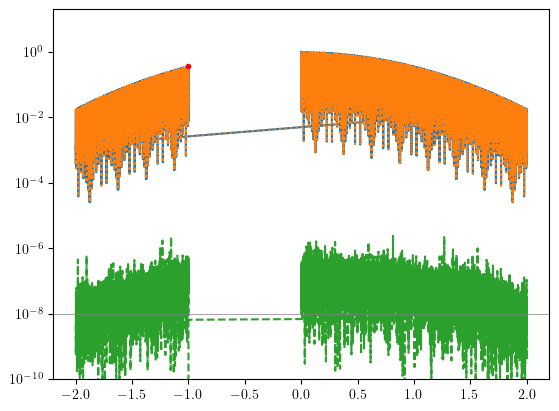

(1.0e-10, 20)

In [98]:
semilogy(xstep, abs.(original))
semilogy(xstep, abs.(tcieval), ":")
semilogy(xstep, abs.(difference), "--")

semilogy([xvals(quantics_to_index(firstpivot)[1])], [f(firstpivot)], "r.")
semilogy([xvals(quantics_to_index(a)[1]) for a in additionalpivots], [abs(f(a)) for a in additionalpivots], "k.")
axhline(tolerance, color="gray", linewidth=0.5)
ylim(tolerance / 100, 20)
#xlim(-10, 10)

In [99]:
analytic = sqrt(pi) * exp(-0.25 / B^2)
sum2 = prod(sum(T, dims=2)[:, 1, :] for T in TCI.tensortrain(tci))[1]
 sum2, analytic

(-18019.70751871575, 0.0)

In [100]:
insetinterval = [0.0, 10B]

@show ib = [round(Int, (i - a) * ndiscretization / (b - a)) for i in insetinterval]

insetstep = div(ib[2] - ib[1], 256)
inseteval = [evaluate_mps(mps, siteinds(mps), index_to_quantics(i, nquantics)) for i in ib[1]:insetstep:ib[2]]
insetorig = [f(index_to_quantics(i, nquantics)) for i in ib[1]:insetstep:ib[2]]
insetdiff = inseteval .- insetorig

insetsamplei = filter(i -> insetinterval[1] <= xvals(quantics_to_index(i)[1]) <= insetinterval[2], keys(cf.d))
insetsamplex = [xvals(quantics_to_index(i)[1]) for i in insetsamplei]
insetsampley = [cf.d[i] for i in insetsamplei]

ib = [round(Int, ((i - a) * ndiscretization) / (b - a)) for i = insetinterval] = [0, 15372286728091]


1-element Vector{Float64}:
 0.4273452926962836

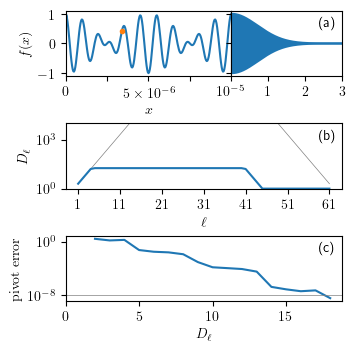

In [112]:
# --- Calculate layout ---
ptperinch = 72

figurew, figureh = (246, 246)
padw, padh = (5, 3)

xlabelh = 34
ylabelw = 42

axw = figurew - padw - ylabelw
axh = (figureh - padh) / 3 - xlabelh

zoomaxw = 0.6 * axw
overvieww = axw - zoomaxw

axbottoms = [(i * axh + (i + 1) * xlabelh) for i in 0:2]
units = [figurew, figureh, figurew, figureh]

# --- end ---

fig = figure(figsize=(figurew/ptperinch, figureh/ptperinch))
    
zoomax = fig.add_axes((ylabelw, axbottoms[3], zoomaxw, axh) ./ units)
overviewax = fig.add_axes((ylabelw + zoomaxw, axbottoms[3], overvieww, axh) ./ units)
bonddimax = fig.add_axes((ylabelw, axbottoms[2], axw, axh) ./ units)
errorax = fig.add_axes((ylabelw, axbottoms[1], axw, axh) ./ units)

insetx = xvals.(ib[1]:insetstep:ib[2])
zoomax.plot(insetx, inseteval)

#zoomax.plot(xvals[ib[1]:insetstep:ib[2]], insetorig, "--")
#zoomax.plot(xvals[ib[1]:insetstep:ib[2]], insetdiff)

zoomax.plot(insetsamplex, insetsampley, ".")

zoomax.set_xlabel(L"$x$")
#zoomax.annotate(
#    L"$x$",
#    xy=(0.5 * axw, -20),
#    xycoords="axes points"
#)

zoomax.set_ylabel(L"$f(x)$")
zoomax.set_xlim(insetinterval)
zoomax.set_xticks(range(insetinterval..., length=5), [L"$0$", "", L"$5\times10^{-6}$", "", L"$10^{-5}$"])

xplot = range(0, 3, length=500)
gauss(x) = exp(-x^2 / A)
overviewax.fill_between(xplot, -gauss.(xplot), gauss.(xplot))
overviewax.plot(xplot, -gauss.(xplot), "tab:blue")
overviewax.plot(xplot, gauss.(xplot), "tab:blue")

faxlim = 1.1
zoomax.set_ylim(-faxlim, faxlim)
overviewax.set_ylim(-faxlim, faxlim)

#zoomax.plot(insetx, -gauss.(insetx), "tab:orange")
#zoomax.plot(insetx, gauss.(insetx), "tab:orange")

#overviewax.plot(xvals[1:step:end], tcieval)
overviewax.set_yticks([-1, 0, 1], ["", "", ""])
overviewax.set_xlim(insetinterval[2], b)
overviewax.set_xticks([1, 2, 3], [L"$1$", L"$2$", L"$3$"])

faxlim = 1.1
zoomax.set_ylim(-faxlim, faxlim)
overviewax.set_ylim(-faxlim, faxlim)

bonddimax.semilogy(1:nquantics-1, [min(2^x, 2^(nquantics-x)) for x in 1:nquantics-1], color="gray", linewidth=0.5)
bonddimax.semilogy(1:nquantics-1, TCI.linkdims(tci))
bonddimax.set_xticks(1:10:nquantics-1)
bonddimax.set_xlabel(L"$\ell$")
bonddimax.set_ylabel(L"$D_\ell$")
bonddimax.set_ylim(1, 1e4)

errorax.semilogy(ranks, errors)
errorax.set_xlim(0)
errorax.set_xlabel(L"$D_\ell$")
errorax.set_ylabel(L"$\mathrm{pivot~error}$")
errorax.axhline(tolerance, color="gray", linewidth=0.5)
errorax.set_yticks([1e-8, 1], [L"$10^{-8}$", L"$10^0$"])

for (ax, label) in zip([overviewax, bonddimax, errorax], "abc")
    ax.annotate(
        "($label)",
        xy=(1, 1),
        xycoords="axes fraction",
        horizontalalignment="right",
        verticalalignment="top",
        xytext=(-4, -4),
        textcoords="offset points"
    );
end

fig.savefig("oned_cosine_gaussian.pdf")